## Setup

Import necessary modules (some can be unneccessary though) and dependencies.

In [25]:
import os
import pathlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from google.colab import drive
import pandas as pd
import soundfile as sf
import librosa

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Mount GoogleDrive and change the directory

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/SpotifyFourthBrainPartnerProject/GoogleSpeechProject/')
!pwd

/content/drive/MyDrive/SpotifyFourthBrainPartnerProject/GoogleSpeechProject


# Explore google speech command data set.

This portion of code expects access speech command data set at "speech_commands_v0.01" folder.

We will not include 'background noise' data in our training.

We will create a list of wake up candidate words.

In [10]:
current_dir = os.getcwd()

In [11]:
# Print all the word in google speech data set
data_dir = os.path.join(current_dir,'speech_commands_v0.01')
folder_names = []
for entry_name in os.listdir(data_dir):
    if (entry_name != '_background_noise_'):
      entry_path = os.path.join(data_dir, entry_name)
      if os.path.isdir(entry_path):
          folder_names.append(entry_name)
wakeup_names = folder_names
print('wake up name list:',wakeup_names)

wake up name list: ['sheila', 'one', 'house', 'down', 'zero', 'yes', 'wow', 'six', 'no', 'bird', 'happy', 'three', 'marvin', 'stop', 'two', 'five', 'off', 'on', 'four', 'dog', 'cat', 'bed', 'up', 'tree', 'nine', 'eight', 'left', 'right', 'go', 'seven']


# Create summary table

Create a summary table ('GoogleSpeechDataList.txt') providing labels and paths for audio files. 

This cell needs to be run only once.

In [12]:
data_dir = os.path.join(current_dir,'speech_commands_v0.01')

df = pd.DataFrame(columns=['real_label','filename','filepath'])
iter = 0
for wakeup_name in wakeup_names:
   filenames = os.listdir(os.path.join(current_dir,'speech_commands_v0.01',wakeup_name)) 
   for filename in filenames:
      #df.loc[iter] = [wakeup_name,filename,os.path.join(current_dir,'speech_commands_v0.01',wakeup_name,filename)]
      df.loc[iter] = [wakeup_name,filename,os.path.join(current_dir,'speech_commands_v0.01',wakeup_name,filename)]
      iter = iter + 1

df.to_csv(os.path.join(current_dir,'GoogleSpeechDataList.txt'))

# Check if the wake word do exist in data base

In [84]:
wake_candid = 'right'
#wake_candid = 'down'

if (wake_candid in wakeup_names):
    print (wake_candid,' is  in our training set,  model will be provided')
else:
    print (wake_candid,' is not  in our training set,  model will not be provided')


right  is  in our training set,  model will be provided


# Create positive and negative examples for wake word candidate.

Number of positive and negative examples in training will be same.

In [85]:
wakedetect = [wake_candid,'not_'+wake_candid]

In [86]:
# Read datasummary

df = pd.read_csv(os.path.join(current_dir,'GoogleSpeechDataList.txt'))  

df_wake = df [df['real_label'] == wake_candid]
df_wake['label'] = df_wake['real_label'] 
df_wake = df_wake[['real_label','filename','filepath','label']]
df_wake = df_wake.sample(frac=1).reset_index(drop=True)

# training,validation,test data set end indices
full_size = len(df_wake)
full_size = 200 # this number will define the total number of positive examples in training+validation+test data set.

# create notwake examples
df_notwake = df [~(df['real_label'] == wake_candid)]
df_notwake['label'] = 'not_'+wake_candid
df_notwake = df_notwake[['real_label','filename','filepath','label']]
df_notwake = df_notwake.sample(frac=1).reset_index(drop=True)

print('total number of wake word samples:', len(df_wake))
print('total number of not wake word samples:', len(df_notwake))

df_subset = pd.concat([df_wake.iloc[:full_size],df_notwake.iloc[:full_size]])
df_subset = df_subset.sample(frac=1).reset_index(drop=True)
print('total number of word in training+val+test data set:', df_subset.shape)

total number of wake word samples: 2367
total number of not wake word samples: 62354
total number of word in training+val+test data set: (400, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


 Make sanity check on summary table

In [87]:
df_subset.head(5)

,real_label,filename,filepath,label
0,right,9aa21fa9_nohash_3.wav,/content/drive/My Drive/SpotifyFourthBrainPart...,right
1,on,e53139ad_nohash_3.wav,/content/drive/My Drive/SpotifyFourthBrainPart...,not_right
2,right,f0ae7203_nohash_0.wav,/content/drive/My Drive/SpotifyFourthBrainPart...,right
3,right,b737ee80_nohash_1.wav,/content/drive/My Drive/SpotifyFourthBrainPart...,right
4,right,24befdb3_nohash_0.wav,/content/drive/My Drive/SpotifyFourthBrainPart...,right


# Create training, validation and test data set

In [88]:
filenamelabels = []
for i in range(len(df_subset)):
  filenamelabels.append([df_subset.loc[i]['filepath'],df_subset.loc[i]['label']])
  #print(i) 
#filenamelabels = tf.random.shuffle(filenamelabels)

In [89]:
full_size = len(filenamelabels)
train_size = int(0.7*full_size)
val_size = int(0.1*full_size)

train_files = filenamelabels[:train_size]
val_files = filenamelabels[train_size: train_size + val_size]
test_files = filenamelabels[-val_size:]

print('training size',len(train_files))
print('validation size',len(val_files))
print('test size',len(test_files))


training size 280
validation size 40
test size 40


#Create helper functions for preprocess

In [90]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(filenamelabel):
  label = filenamelabel[1]
  audio_binary = tf.io.read_file(filenamelabel[0])
  waveform = decode_audio(audio_binary)
  return waveform, label

# Augment training data

Create functions which add noise, changes pitches and shiftes sounds to create more data for training

In [91]:
def add_normal_noise(wav,noise_level=0.005):
  return wav + noise_level*np.random.normal(0,1,len(wav))
def shift_wave(wav,roll=3):
  return np.roll(wav,int(len(wav)/roll))  
def stretch_wave(wav,factor=0.4):
  return librosa.effects.time_stretch(wav.numpy(),factor)
def pitchshift_wave(wav,shift_steps=-2):
  return librosa.effects.pitch_shift(wav.numpy(),len(wav.numpy()),shift_steps) 

In [92]:
if os.path.isdir('temp_aug'):
  ! rm temp_aug -rf
! mkdir temp_aug
train_files_aug = []

for i in range(int(len(train_files)/20)):
    
    waveform, label = get_waveform_and_label(train_files[i])
    
    noise_wav = add_normal_noise(waveform)
    shifted_wav = shift_wave(waveform)
    lowpitch_wav = pitchshift_wave(waveform,shift_steps=-2)
    highpitch_wav = pitchshift_wave(waveform,shift_steps=2)
    
    filepath, label = train_files[i]
    filename = filepath.split('/')[-1].split('.')[0]
    filename_noise = os.path.join(current_dir,'temp_aug',filename+'noise'+'.wav')
    filename_shifted = os.path.join(current_dir,'temp_aug',filename+'shifted'+'.wav')
    filename_lowpitch = os.path.join(current_dir,'temp_aug',filename+'lowpitch'+'.wav')
    filename_highpitch = os.path.join(current_dir,'temp_aug',filename+'highpitch'+'.wav')

    sf.write(filename_noise,noise_wav,16000)
    sf.write(filename_shifted,shifted_wav,16000)
    sf.write(filename_lowpitch,lowpitch_wav,16000)
    sf.write(filename_highpitch,highpitch_wav,16000)
    
    train_files_aug.append([filename_noise,label])
    train_files_aug.append([filename_shifted,label])
    train_files_aug.append([filename_lowpitch,label])
    train_files_aug.append([filename_highpitch,label])
print(len(train_files_aug))

56


In [93]:
train_files =  train_files + train_files_aug

In [94]:
train_files = tf.random.shuffle(train_files)
val_files = tf.random.shuffle(val_files)
test_files = tf.random.shuffle(test_files)

In [95]:
AUTOTUNE = tf.data.AUTOTUNE
files_train = tf.data.Dataset.from_tensor_slices(train_files)
waveform_train = files_train.map(get_waveform_and_label,num_parallel_calls=AUTOTUNE)

# Explore waveforms from training data set

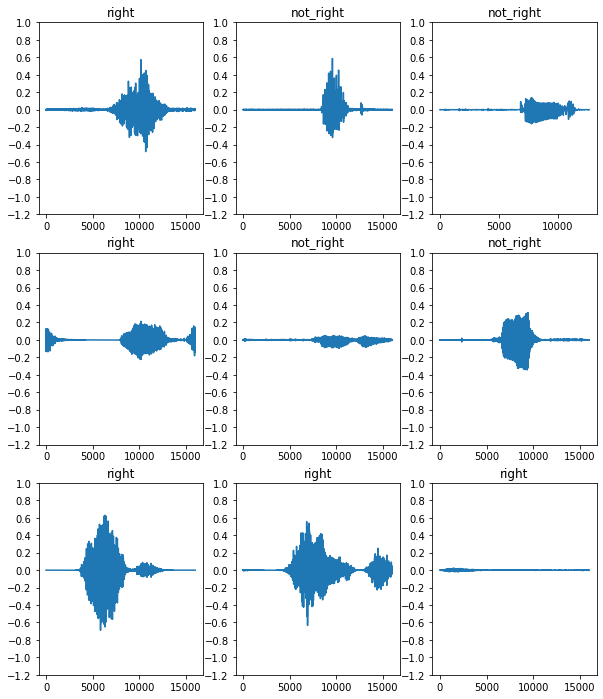

In [96]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_train.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

#Transform data with STFT

Define get_spectrogram function - which converts time domain information to a 2D (time+frequency) map for neural network training

In [97]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [98]:
# sanity check
for waveform, label in waveform_train.take(2):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: not_right
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


# Create helper functions for training

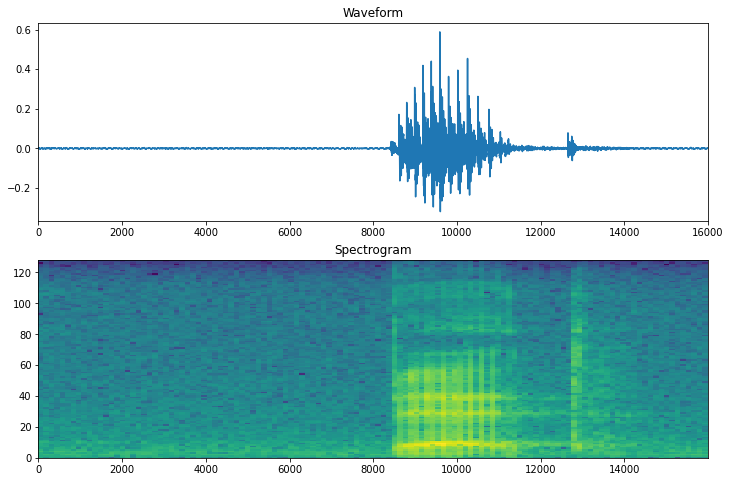

In [99]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [100]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == wakedetect)
  return spectrogram, label_id

In [101]:
spectrogram_train = waveform_train.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


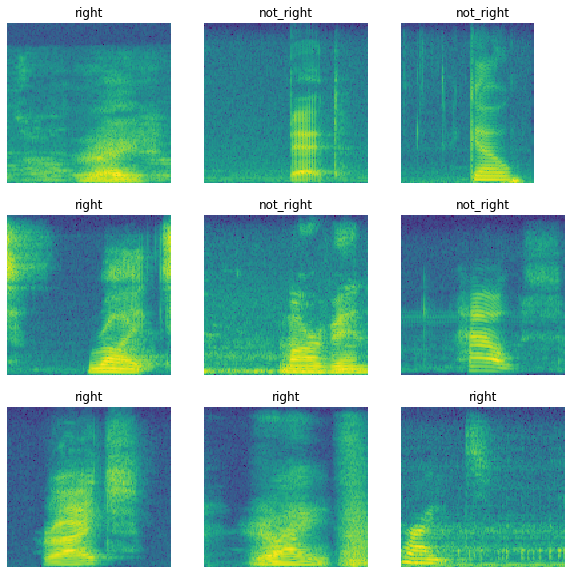

In [102]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_train.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(wakedetect[label_id.numpy()])
  ax.axis('off')
  
plt.show()

# Preprocess data sets

In [103]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [104]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [105]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [106]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [107]:
#sanity check
for spectrogram, _ in spectrogram_train.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (124, 129, 1)


# Model training (simple CNN)

In [108]:
num_labels = len(wakedetect)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_train.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)            

In [109]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [110]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
6/6 [==============================] - 7s 1s/step - loss: 0.7030 - accuracy: 0.5893 - val_loss: 0.7769 - val_accuracy: 0.4250
Epoch 2/10
6/6 [==============================] - 0s 14ms/step - loss: 0.6196 - accuracy: 0.6637 - val_loss: 0.7492 - val_accuracy: 0.5000
Epoch 3/10
6/6 [==============================] - 0s 14ms/step - loss: 0.5673 - accuracy: 0.6905 - val_loss: 0.7853 - val_accuracy: 0.4750
Epoch 4/10
6/6 [==============================] - 0s 15ms/step - loss: 0.5105 - accuracy: 0.7560 - val_loss: 0.7633 - val_accuracy: 0.5500
Epoch 00004: early stopping


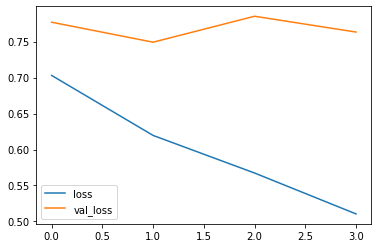

In [111]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [112]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [113]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy for cnn: {test_acc:.0%}')

Test set accuracy for cnn: 60%


# Save model

In [114]:
model_path = 'GoogleSpeechDataset_wakeword_'+wake_candid+'.h5'
print(model_path)
tf.saved_model.save(model, model_path)

GoogleSpeechDataset_wakeword_right.h5

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: GoogleSpeechDataset_wakeword_right.h5/assets
